In [31]:
from __future__ import with_statement
import numpy as np

First, open an ssh tunnel to the CatSim database hosted by the University of Washington.  Open a terminal window and type

```
ssh -L 51433:fatboy.phys.washington.edu:1433 simsuser@gateway.astro.washington.edu
```

There is some configuration that you will have to do to make sure this works.  Instructions are here:

https://confluence.lsstcorp.org/display/SIM/Accessing+the+UW+CATSIM+Database

Now, we need to specify the download a database of OpSim-simulated pointings from

https://www.lsst.org/scientists/simulations/opsim/opsim-surveys-data-directory

and specify its location with the ```opsimdb``` variable

In [32]:
import os
opsimdb = os.path.join("/Users","danielsf","physics")
opsimdb = os.path.join(opsimdb, "lsst_150412", "Development", "garage")
opsimdb = os.path.join(opsimdb, "OpSimData", "minion_1016_sqlite.db")

Connections to the CatSim database of celestial objects are handled via the classes stored in ```lsst.sims.catUtils.baseCatalogModels```.  To see what's available, you can use

In [33]:
import lsst.sims.catUtils.baseCatalogModels as baseCatalogModels

dir(baseCatalogModels)

['BaseCatalogConfig',
 'BaseCatalogModels',
 'BaseCatalogObj',
 'BhbStarObj',
 'BrightStarObj',
 'CepheidStarObj',
 'CometObj',
 'DwarfGalStarObj',
 'EasterEggStarObj',
 'EbStarObj',
 'GalaxyAgnObj',
 'GalaxyBulgeObj',
 'GalaxyDiskObj',
 'GalaxyModels',
 'GalaxyObj',
 'GalaxyTileCompoundObj',
 'GalaxyTileObj',
 'ImageAgnObj',
 'LensGalaxyObj',
 'MBAObj',
 'MiscSolarSystemObj',
 'MsStarObj',
 'NEOObj',
 'OpSim3_61DBObject',
 'RRLyStarObj',
 'SNDBObj',
 'SolarSystemObj',
 'SsmModels',
 'StarBase',
 'StarModels',
 'StarObj',
 'WdStarObj',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'snModels']

or the confluence page

https://confluence.lsstcorp.org/display/SIM/Database+Schema

For this tutorial, will instantiate a connection to the table of RRLyrae

In [34]:
from lsst.sims.catUtils.baseCatalogModels import RRLyStarObj
stardb = RRLyStarObj()

Now we will create a LightCurveGenerator, connecting it to both our database of celestial objects and our database of simulated pointings

In [35]:
from lsst.sims.catUtils.utils import StellarLightCurveGenerator
lc_gen = StellarLightCurveGenerator(stardb, opsimdb)

Now let us query our database of pointings for all of the pointings in a range of RA and Dec and a set of filters

In [36]:
raRange = (60.0, 65.0)
decRange = (-15.0, -10.0)
bandpass = ('g', 'r', 'i')
pointings = lc_gen.get_pointings(raRange, decRange, bandpass=bandpass)

parameters (60.0, 65.0) (-15.0, -10.0) ('g', 'r', 'i') None


`pointings` is now a 2-D list.  Each row of the list is a set of pointings (represented by instantiations of the `ObservationMetaData` class) at different dates and through different filters but centered on the same patch of sky.

In [37]:
print(len(pointings))

3


Now we will use the `LightCurveGenerator` to extract the light curves of all of the objects in our selected pointings.

In [38]:
lc_dict, truth_dict = lc_gen.light_curves_from_pointings(pointings)

starting query
query took  0.11227202415466309
starting query
query took  0.1597890853881836
starting query
query took  0.11198782920837402
light curves took 7.219829e+00 seconds to generate


Let's analyze one of these light curves using the `gatspy` time series analysis package described here

https://jakevdp.github.io/blog/2015/06/13/lomb-scargle-in-python/

In [39]:
lc = lc_dict[853673991]

For better or worse, variability in CatSim is represented as a json-encoded dict that points to a light curve which lives in the lsst `sims_sed_library` package.

In [40]:
print(truth_dict[853673991])

{"pars":{"filename":"rrly_lc/RRab/1981725_per.txt", "tStartMjd":3.335375066201238e+004}, "varMethodName":"applyRRly"}


Inspecting the `1981625_per.txt` light curve file, we see that this corresponds to an RR Lyra with a period of 0.485873 days.

Let's first just plot one of our light curves.

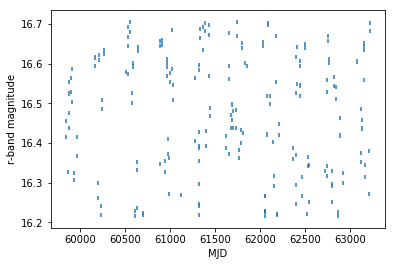

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.errorbar(lc['r']['mjd'], lc['r']['mag'], lc['r']['error'],
            fmt='', linestyle='None')
ax.set(xlabel='MJD', ylabel='r-band magnitude')

Now let's construct a Lomb-Scargle periodogram

[(0.0001, 1.0)]

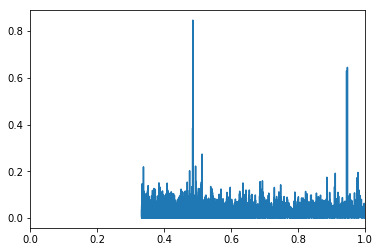

In [42]:
from gatspy.periodic import LombScargleFast
model = LombScargleFast().fit(lc['r']['mjd'], lc['r']['mag'],
                              lc['r']['error'])
periods, power = model.periodogram_auto(nyquist_factor=100)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0.0001, 1.0))

Now let's find the highest-power period

In [43]:
type(model)


gatspy.periodic.lomb_scargle_fast.LombScargleFast

In [44]:
model.optimizer.period_range = (0.1, 1.4)
best_period = model.best_period
print(best_period)

Finding optimal frequency:
 - Estimated peak width = 0.00186
 - Using 5 steps per peak; omega_step = 0.000372
 - User-specified period range:  0.1 to 1.4
 - Computing periods at 156928 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
0.485871142483


As you can see, it is very close to our expected period of 0.485873 days.

Now let's analyze several light curves.  We will start by scraping the light curve files in `sims_sed_library` to get their periods.

In [45]:
from lsst.utils import getPackageDir
import time

t_start = time.time()

reference_dict = {}
truth_dir = os.path.join(getPackageDir('sims_sed_library'), 'rrly_lc')

rrab_dir = os.path.join(truth_dir, 'RRab')
rrc_dir = os.path.join(truth_dir, 'RRc')

for file_name in os.listdir(rrab_dir):
    if 'per' in file_name:
        full_name = os.path.join(rrab_dir, file_name)
        with open(full_name, "r") as input_file:
            for line in input_file:
                vv = line.split()
                if vv[1] == 'Period':
                    reference_dict['rrly_lc/RRab/'+file_name] = float(vv[3])
                    break

for file_name in os.listdir(rrc_dir):
    if 'per' in file_name:
        full_name = os.path.join(rrc_dir, file_name)
        with open(full_name, "r") as input_file:
            for line in input_file:
                vv = line.split()
                if vv[1] == 'Period':
                    reference_dict['rrly_lc/RRc/'+file_name] = float(vv[3])
                    break


Now let's loop through the first 10 light curves and calculate their highest-power periods.

In [46]:
import json

true_period = []
found_period = []

for kk in list(lc_dict.keys())[:10]:
    lc_obj = lc_dict[kk]
    truth = json.loads(truth_dict[kk])
    file_name = truth['pars']['filename']
    for ff in list(lc_obj.keys())[:1]:
        lc = lc_obj[ff]

        model = LombScargleFast().fit(lc['mjd'], lc['mag'],
                                      lc['error'])
        model.optimizer.period_range = (0.1, 1.4)
        best_period = model.best_period
        true_period.append(reference_dict[file_name])
        found_period.append(best_period)

true_period = np.array(true_period)
found_peroid = np.array(found_period)

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.1 to 1.4
 - Computing periods at 159151 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.1 to 1.4
 - Computing periods at 159151 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.1 to 1.4
 - Computing periods at 159151 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.1 to 1.4
 - Computing periods at 159151 steps
Zooming-in on 5 candidate peaks:

Comparing to the true periods in our light curve files, we find very good agreement.

In [47]:
for tt, ff in zip(true_period, found_period):
    print(tt, ff)

0.499788 0.499783879203
0.622184 0.622197385829
0.519668 0.519664820029
0.74297 0.742969569551
0.565397 0.565398053065
0.603456 0.603461616185
0.71533 0.715328783451
0.549881 0.549880333314
0.716773 0.716771611366
0.587908 0.587903631365


# Generating your own cadence

The work above used an OpSim-generated database of observations to define the observing cadence in the light curves.  If you want to experiment with your own cadence, you will need to mock the OpSim database.

The relevant table is the `Summary` table, whose schema can be found here

https://www.lsst.org/scientists/simulations/opsim/summary-table-column-descriptions-v335

Below: we will generate a somewhat random set of observations and construct a sqlite database that contains the relevant columns of the `Summary` table and use that as our cadence for light curve generation.

In [48]:
from lsst.sims.utils import ObservationMetaData, solarRaDec
from lsst.sims.utils import altAzPaFromRaDec

import warnings

# suppress some warnings raised by astropy.time when you
# calculate the relationship between UT1 and UTC in the future
warnings.filterwarnings('ignore',message=".*UT1-UTC.*")

rng = np.random.RandomState(87)

# pick a point on the sky to center our observations
field_ra = 112.0
field_dec = -31.0

# generate a random sample of MJDs
mjd_candidates = rng.random_sample(1000)*3653.0+59580.0
mjd_candidates.sort()

obs_list = [ObservationMetaData(mjd=mm) for mm in mjd_candidates]

# calculate the altitude and azimuth of the sun at those MJDs
solar_alt = []
solar_az = []
for obs in obs_list:
    rr, dd = solarRaDec(obs.mjd)
    alt, az, pp = altAzPaFromRaDec(rr, dd, obs)
    solar_alt.append(alt)
    solar_az.append(az)  

print("getting solar ra dec took ",time.time()-t_start)

# select only those MJDs where the sun is at least 10 degrees below
# the horizon
solar_alt = np.array(solar_alt)
solar_az = np.array(solar_az)

dexes_sundown = np.where(solar_alt<-10.0)
print(len(dexes_sundown[0]))

n_time = len(dexes_sundown[0])

# further select MJDs where our field is more thatn 45 degrees
# above the horizon
obs_list = np.array(obs_list)[dexes_sundown]
alt_list = []
az_list = []
for obs in obs_list:
    alt, az, pp = altAzPaFromRaDec(field_ra, field_dec, obs)
    alt_list.append(alt)
    az_list.append(az)

alt_list = np.array(alt_list)
dexes = np.where(alt_list>45.0)

mjd_list = np.array([obs.mjd.TAI for obs in obs_list[dexes]])
airmass_list = np.array([1.0/np.cos(0.5*np.pi-alt)
                         for alt in np.radians(alt_list[dexes])])
print(len(mjd_list))

getting solar ra dec took  15.464292049407959
460
112


Load throughputs for the LSST bandpasses and site atmosphere at different airmasses

In [49]:
import time
t_start = time.time()
from lsst.utils import getPackageDir
from lsst.sims.photUtils import BandpassDict
atmos_dir = os.path.join(getPackageDir('throughputs'), 'atmos')
bp_dict = {}
hw_dict = {}
for airmass in np.arange(1.0, 2.6, 0.1):
    am_int = int(10*airmass)
    atmos_name = os.path.join(atmos_dir, 'atmos_%d.dat' % am_int)
    bp, hw = \
    BandpassDict.loadBandpassesFromFiles(atmoTransmission=atmos_name)
    bp_dict[am_int] = bp
    hw_dict[am_int] = hw
print("that took ",time.time()-t_start)

that took  33.23592495918274


Generate random seeing values.

In [50]:
fwhm_eff_list = rng.random_sample(len(mjd_list))*0.1+0.65

Use the `sims_skybrightness` package to calculate the sky brightness and 5-sigma limiting magnitude at these MJDs.

In [51]:
t_start = time.time()

import warnings
warnings.filterwarnings('ignore', message='.*UT1-UTC.*')

from lsst.sims.skybrightness import SkyModel
model = SkyModel(lowerAtm=True, upperAtm=True, scatteredStar=True)

from lsst.sims.utils import altAzPaFromRaDec
from lsst.sims.photUtils import Sed, calcM5, PhotometricParameters

bp_name_options = np.array(['g', 'r', 'i'])
bp_name_list = bp_name_options[rng.random_integers(0,2,
                                len(mjd_list))]
photParams = PhotometricParameters()

m5_list = []
sky_brightness_list = []

for mjd, airmass, fwhm, bp_name in \
    zip(mjd_list, airmass_list,
        fwhm_eff_list, bp_name_list):
        
    model.setRaDecMjd(field_ra, field_dec, mjd, degrees=True)
    wv, fl = model.returnWaveSpec()
    ss = Sed(wavelen=wv, flambda=fl[0])
    am_int = int(10*airmass)
    m5 = calcM5(ss,
                bp_dict[am_int][bp_name],
                hw_dict[am_int][bp_name],
                photParams, FWHMeff=fwhm)
    m5_list.append(m5)
    sky_brightness_list.append(ss.calcMag(bp_dict[am_int][bp_name]))

print("that took ",time.time()-t_start)

/Users/danielsf/physics/lsst_171025/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_skybrightness/2.7.0.sims/python/lsst/sims/skybrightness/skyModel.py:209: UserWarning: Adding component multiple times to the final output spectra.
  warnings.warn("Adding component multiple times to the final output spectra.")
/Users/danielsf/physics/lsst_171025/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: This function is deprecated. Please call randint(0, 2 + 1) instead
  


that took  8.505199909210205


In [52]:
m5_list = np.array(m5_list)
sky_brightness_list = np.array(sky_brightness_list)
print(sky_brightness_list.min())
print(sky_brightness_list.max())
print(field_ra)
print(field_dec)

17.9100034492
22.1698155192
112.0
-31.0


Create a sqlite database using the mock observation data we have just created.

In [53]:
import sqlite3
db_file_name = "example_test_cadence.db"
if os.path.exists(db_file_name):
    os.unlink(db_file_name)
conn = sqlite3.connect(db_file_name)
cc = conn.cursor()
cc.execute('''CREATE TABLE Summary
              (fieldRA float, fieldDec float, expMJD float,
              filter text, FWHMeff float, fiveSigmaDepth float,
              filtSkyBrightness float)''')

for mjd, bp, fwhm, m5, bright in \
zip(mjd_list, bp_name_list, fwhm_eff_list, m5_list, sky_brightness_list):
    cmd = '''INSERT INTO Summary VALUES(%.5f, %.5f, %.3f, '%s', %.5f, %.5f, %.5f)''' \
    % (np.radians(field_ra), np.radians(field_dec), mjd, bp, fwhm, m5,
      bright)
    cc.execute(cmd)
conn.commit()
conn.close()

Generate light curves using our mock pointing database

In [54]:
gen = StellarLightCurveGenerator(stardb, db_file_name)

In [55]:
pointings = gen.get_pointings((field_ra-1.0, field_ra+1.0),
                              (field_dec-1.0, field_dec+1.0),
                              bandpass=('g','r','i'))

parameters (111.0, 113.0) (-32.0, -30.0) ('g', 'r', 'i') None


In [56]:
len(pointings)

1

In [57]:
len(pointings[0])

112

In [58]:
lc, truth = gen.light_curves_from_pointings(pointings)

starting query
query took  0.26886725425720215
light curves took 7.821352e+00 seconds to generate


In [59]:
len(lc)

82